In [1]:
import torch
from torch import nn

# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [2]:
image = "data/NORMAL/IM-0001-0001.jpeg"

In [175]:
from PIL import Image
import torchvision.transforms as transforms
import torch

# Dosya yolunu kullanarak resmi yükleyin
image_path = 'data/NORMAL/IM-0011-0001-0002.jpeg'  # Resmin dosya yolu
image = Image.open(image_path)
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Boyutu 256x256 piksel yapar
    transforms.ToTensor()  # Tensora dönüştürme işlemi
])
# Resmi tensora dönüştürün
tensor_image = transform(image)

In [176]:
tensor_image.shape

torch.Size([1, 512, 512])

In [256]:
from PIL import Image
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os
data_dir = 'data/'  # Veri klasörünün yolu
batch_size = 64  # Mini-batch boyutu

# Veri dönüşümleri ve etiketleme işlemi
transform = transforms.Compose([
    transforms.Resize((224, 224)),   
    transforms.ToTensor(),
])

dataset = ImageFolder(root=data_dir, transform=transform)


In [257]:
first_item = dataset[1582]  # Veri kümesinin ilk öğesini alın
img_path, label = first_item

In [258]:
type(dataset[0])

tuple

In [259]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [260]:
dataloader

In [ ]:
for images, labels in dataloader:
    

In [261]:
train_batch, label_batch = next(iter(dataloader))

In [262]:
label_batch

tensor([0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
        0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [263]:
new_dataset = []
for img, label in zip(train_batch,label_batch):
    new_dataset.append((img,label))

In [264]:
new_dataloader = DataLoader(new_dataset, batch_size=4, shuffle=True)

In [265]:
train_batch, label_batch = next(iter(new_dataloader))

In [282]:
output = model(train_batch)
output

tensor([[-0.0124],
        [-0.0138],
        [-0.0151],
        [-0.0125]], grad_fn=<AddmmBackward0>)

In [283]:
torch.sigmoid(output)

tensor([[0.4969],
        [0.4966],
        [0.4962],
        [0.4969]], grad_fn=<SigmoidBackward0>)

In [284]:
torch.round(torch.sigmoid(output)).squeeze()

tensor([0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

In [286]:
y_pred = torch.round(torch.sigmoid(output)).squeeze().to(torch.float)
y_pred

tensor([0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

In [287]:
y = label_batch.to(torch.float)
y

tensor([1., 0., 1., 0.])

In [288]:
loss_fn(y_pred, y)

tensor(50., grad_fn=<BinaryCrossEntropyBackward0>)

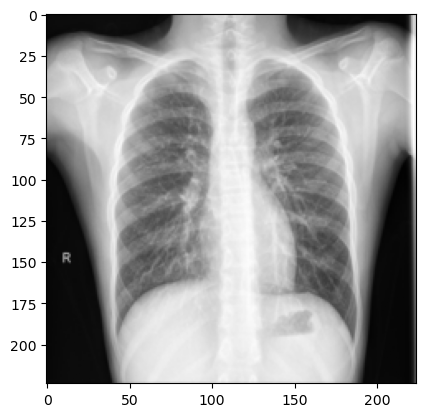

In [267]:
import numpy as np
img, label = new_dataset[0]
img = np.transpose(img, (1, 2, 0))
"""Görünüşe göre bu hatanın nedeni, görüntünün kanal sırasının yanlış olmasıdır. 
PyTorch, görüntüleri varsayılan olarak "kanal, yükseklik, genişlik" (CHW) sırasına beklerken,
genellikle kullanılan diğer kütüphaneler "yükseklik, genişlik, kanal" (HWC) sırasını kullanır."""

plt.imshow(img)
plt.show()

In [250]:
class rontgen(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3),
            nn.ReLU(),
            nn.AvgPool2d(2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3),
            nn.ReLU(),
            nn.AvgPool2d(2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*53*53, out_features=output_shape),
            
        )
        
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        
        return x

In [197]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [198]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        model.train()
        X, y = X.to(device), y.to(device)
        y = y.to(torch.float)
        # 1. Forward pass
        y_pred_logits = model(X)
        y_pred = torch.round(torch.sigmoid(y_pred_logits)).squeeze().to(torch.float).unsqueeze(dim=0)
        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            y = y.to(torch.float)
            # 1. Forward pass
            test_pred_logits = model(X)
            y_pred = torch.round(torch.sigmoid(test_pred_logits)).squeeze().to(torch.float).unsqueeze(dim=0)
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=y_pred # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [268]:
model = rontgen(input_shape=3,hidden_units=10, output_shape=1)
model

rontgen(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=28090, out_features=1, bias=True)
  )
)

In [269]:
torch.sigmoid(model(img_path.unsqueeze(dim=0)))

tensor([[0.4969]], grad_fn=<SigmoidBackward0>)

In [270]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [285]:
from helper_functions import accuracy_fn
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001)

In [289]:

from tqdm import tqdm
# Measure time

# Train and test model 
epochs = 10
train_loss, train_acc = 0,0
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    for X, y in new_dataloader:
        model.train()
        output = model(X)
        y = y.to(torch.float)
        y_pred = torch.round(torch.sigmoid(output)).squeeze().to(torch.float)
        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred) # Go from logits -> pred labels
        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(new_dataloader)
    train_acc /= len(new_dataloader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
  

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------


 10%|████████▎                                                                          | 1/10 [00:03<00:32,  3.63s/it]

Train loss: 46.87500 | Train accuracy: 53.12%
Epoch: 1
---------


 20%|████████████████▌                                                                  | 2/10 [00:06<00:25,  3.18s/it]

Train loss: 49.80469 | Train accuracy: 56.45%
Epoch: 2
---------


 30%|████████████████████████▉                                                          | 3/10 [00:09<00:21,  3.13s/it]

Train loss: 49.98779 | Train accuracy: 56.65%
Epoch: 3
---------


 40%|█████████████████████████████████▏                                                 | 4/10 [00:12<00:18,  3.14s/it]

Train loss: 49.99924 | Train accuracy: 56.67%
Epoch: 4
---------


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:15<00:15,  3.18s/it]

Train loss: 49.99995 | Train accuracy: 56.67%
Epoch: 5
---------


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:19<00:12,  3.19s/it]

Train loss: 50.00000 | Train accuracy: 56.67%
Epoch: 6
---------


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:22<00:09,  3.22s/it]

Train loss: 50.00000 | Train accuracy: 56.67%
Epoch: 7
---------


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:25<00:06,  3.26s/it]

Train loss: 50.00000 | Train accuracy: 56.67%
Epoch: 8
---------


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:29<00:03,  3.24s/it]

Train loss: 50.00000 | Train accuracy: 56.67%
Epoch: 9
---------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:32<00:00,  3.23s/it]

Train loss: 50.00000 | Train accuracy: 56.67%


# ornek deneme

In [244]:
hidden_units = 10
output_shape = 1

block_1 = nn.Sequential(
            nn.Conv2d(in_channels=img.shape[0], out_channels=hidden_units, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*53*53, out_features=output_shape),
            
        )

In [245]:
img, label = new_dataset[0]
img.shape[0]

3

In [246]:
img.shape

torch.Size([3, 224, 224])

In [247]:
x = block_1(train_batch)
print(x.shape)
x = block_2(x)
print(x.shape)
x = classifier(x)
print(x.shape)

torch.Size([4, 10, 110, 110])
torch.Size([4, 10, 53, 53])
torch.Size([4, 1])


In [207]:
y_pred = torch.round(torch.sigmoid(x)).squeeze().to(torch.float)

In [208]:
y_pred

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], grad_fn=<SqueezeBackward0>)

In [209]:
y = label_batch.to(torch.float)
y

tensor([0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0.,
        1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
        0., 0., 1., 0., 0., 1., 1., 1., 1., 0.])

In [210]:
loss_fn(y_pred, y)


tensor(0.6570, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)